<h1>Generalized Autoregressive Moving Average Data Simulation</h1>

In [1]:
import numpy as np
from scipy.signal import lfilter
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.tools import (
    constrain_stationary_univariate, unconstrain_stationary_univariate)
import sympy as sym
import pandas as pd
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline


In [2]:
# Construct the model
class ARMAm(sm.tsa.statespace.MLEModel):
    def __init__(self, endog, ar, ma):
        order = max(ar, ma+1)
        self.order_sum = ar + ma
        self.ar = ar
        self.ma = ma
        # Initialize the state space model
        super(ARMAm, self).__init__(endog, k_states=order, k_posdef=1,
                                  initialization='stationary')

        # Setup the fixed components of the state space representation
        self['design'] = np.r_[1, np.zeros(self.k_states-1)]
        '''
        self['transition'] = [[0, 1, 0, 0],
                                  [0, 0, 1, 0],
                                     [0, 0, 0, 1],
                                        [0, 0, 0, 0]]
        self['selection'] = [[1], [0], [0], [0]]
        '''
        
        self['transition'] = np.eye(self.k_states, k = 1)
        self['selection', 0, 0] = 1
        
        self.positive_parameters = slice(self.order_sum+1,self.order_sum+2)

    # Describe how parameters enter the model
    def update(self, params, transformed=True, **kwargs):
        params = super(ARMAm, self).update(params, transformed, **kwargs)

        self['transition', :self.ar, 0] = params[:self.ar]
        self['selection', 1:, 0] = params[self.ar:self.order_sum]
        self['state_cov', 0, 0] = params[self.order_sum]
        

    # Specify start parameters and parameter names
    @property
    def start_params(self):
        ini = np.zeros(self.order_sum+1)+0.001
        ini[-1] = 1
        return ini  # these are very simple
    
    def transform_params(self, unconstrained):
        """
        We constraint the last three parameters
        ('var.e', 'var.x.coeff', 'var.w.coeff') to be positive,
        because they are variances
        """
        constrained = unconstrained.copy()
        constrained[self.positive_parameters] = (
            constrained[self.positive_parameters] ** 2
        )
        
        for i in range(self.order_sum):
            constrained[i] = constrain_stationary_univariate(constrained[i:i+1])
        '''
        constrained[0] = constrain_stationary_univariate(constrained[0:1])
        constrained[1] = constrain_stationary_univariate(constrained[1:2])
        constrained[2] = constrain_stationary_univariate(constrained[2:3])
        constrained[3] = constrain_stationary_univariate(constrained[3:4])
        constrained[4] = constrain_stationary_univariate(constrained[4:5])
        constrained[5] = constrain_stationary_univariate(constrained[5:6])
        '''
        return constrained

    def untransform_params(self, constrained):
        """
        Need to unstransform all the parameters you transformed
        in the `transform_params` function
        """
        unconstrained = constrained.copy()
        unconstrained[self.positive_parameters] = (
            unconstrained[self.positive_parameters] ** 0.5
        )
        for i in range(self.order_sum):
            unconstrained[i] = unconstrain_stationary_univariate(constrained[i:i+1])
        return unconstrained

<li>ARpMAq<ol>
    <li>Phi: autoregression weight</li>
    <li>Theta: moving average weight</li>
    <li>Sigma: variance of noise</li>
    <li>obs_cov</li>
    <li>state_cov</li>
    </ol>
</li>
<br>
    
\begin{equation*}
{\phi}(L)y_{t} = {\theta}(L)\epsilon_t \\
(1-\sum_{1=1}^p \phi_iL^i)y_t = (1+\sum_{1=1}^q \theta_iL^i)\epsilon_t \\
\epsilon_t \sim N(0,\sigma^2)\\
\end{equation*}

State Space Representation (Harvey):
\begin{equation*}
d = max(p, q+1) \\
y_{t} = \begin{vmatrix}
1 & 0 & ... & 0 & 0
\end{vmatrix} \alpha_t \\
\alpha_{t+1} = \begin{vmatrix}
\phi_1 & 1 & 0 & ... & 0\\
\phi_2 & 0 & 1 & ... & 0\\
... & ... & ... & ... & ...\\
\phi_{d-1} & 0 & 0 & ... & 1 \\
\phi_d & 0 & 0 & ... & 0
\end{vmatrix} \alpha_t + \begin{vmatrix}
1 \\
\theta_1 \\
... \\
\theta_{d-1} \\
\theta_d
\end{vmatrix} \mu_t \\
\phi_i = 0 \quad \textrm{for} \quad i > p\\
\theta_j = 0 \quad \textrm{for} \quad j > q\\
\mu_t = \epsilon_{t+1} \sim N(0,\sigma^2)
\end{equation*}


Derivation of data simulation from the system above (q: Companion matrix):
\begin{equation*}
y_{t} =  c\alpha_t \\
\alpha_{t+1} =  q\alpha_t +  d\mu_t \\
\end{equation*}

Tranform into Laplace domain: 
\begin{equation*}
y_{t} =  c\alpha_t \\
\alpha_{t+1} =  q\alpha_t +  d\mu_t \\
\downarrow\\
Y_{s} =  CA_s \\
\frac{1}{s}A_{s} =  QA_s +  DM_s \\
\downarrow\\
Y_{s} =  CA_s \\
(\frac{1}{s}-Q)A_s = DM_s \\
\downarrow\\
Y_{s} =  CA_s \\
A_s = (\frac{1}{s}-Q)^{-1}DM_s \\
\downarrow\\
Y_{s} =  C(\frac{1}{s}-Q)^{-1}DM_s \\
\downarrow\\
H_s = \frac{Y_s}{M_s} = C(\frac{1}{s}-Q)^{-1}D
\end{equation*}

In [12]:
# True model parameters
nobs = int(1e5)
true_phi = np.r_[0.5, -0.2, 0.6]
true_theta = np.r_[0.3, -0.5, 0.8]
true_sigma = 1**0.5


In [13]:
p = len(true_phi)
q = len(true_theta)
d = max(p,q+1)

Q = np.eye(d,k=1)
Q[:p,0] = true_phi

sym.init_printing()
s = sym.symbols('s')
s_ = sym.Matrix(np.eye(d, dtype=int)*1/s)
phi = s_ - Q

phi_inv = phi.inv()

D = np.zeros((d,1))
D[:q+1,0] = np.r_[1,true_theta]

C_np = np.zeros((1,d))
C_np[0,0] = 1
C = sym.Matrix(C_np)

trans = sym.simplify(C*phi_inv*D)

n,d = sym.fraction(trans[0])
a = sym.poly(n, s)
b = sym.poly(d, s)
n_coeffs = a.all_coeffs()
d_coeffs = b.all_coeffs()
n_coeffs.reverse()
d_coeffs.reverse()
trans_num = np.r_[n_coeffs].astype(None)
trans_den = np.r_[d_coeffs].astype(None)

nobs = int(1e3)
true_sigma = 1**0.5
# Simulate a time series
np.random.seed(1234)
disturbances = np.random.normal(0, true_sigma, size=(nobs,))
endogARMAm = lfilter(trans_num, trans_den, disturbances)

/Users/theok/miniforge3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


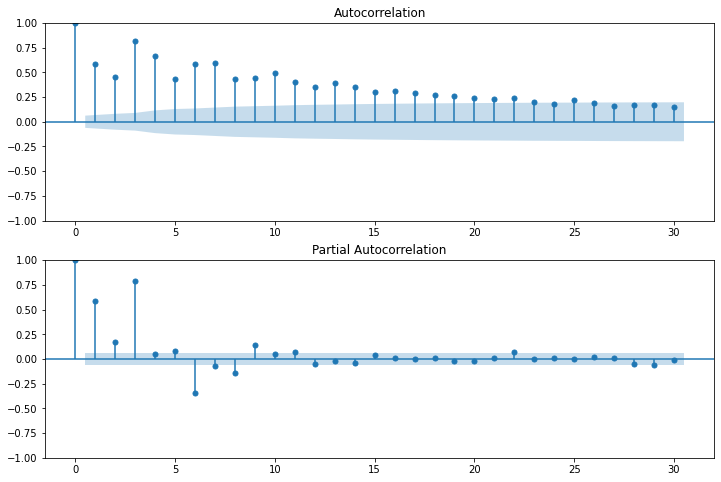

In [14]:
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(endogARMAm.squeeze(), lags=30, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(endogARMAm.squeeze(), lags=30, ax=ax2)

In [15]:
mod = ARMAm(endogARMAm,3,3)
res = mod.fit()
print(res.summary())

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.42741D+00    |proj g|=  5.77945D+00

At iterate    5    f=  1.60822D+00    |proj g|=  6.46982D-02

At iterate   10    f=  1.59944D+00    |proj g|=  8.85689D-03

At iterate   15    f=  1.59933D+00    |proj g|=  2.15072D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     17     20      1     0     0   8.120D-05   1.599D+00
  F =   1.5993275328148198     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
        

 This problem is unconstrained.


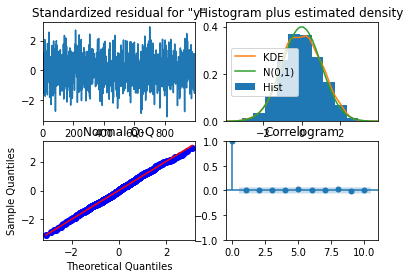

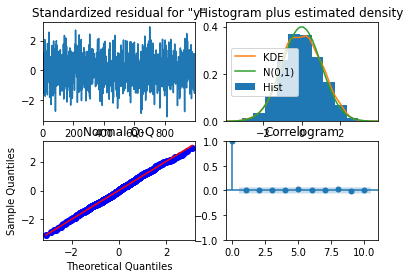

In [7]:
res.plot_diagnostics()

<h2>Jarque-Bera: [test_statistic, pvalue, skewness, kurtosis] </h2>
<h3>Goodness of fit </h3>

In [108]:
print(res.test_normality(method='jarquebera'))

[[ 2.94447327  0.2294118  -0.00331268  2.73424925]]


<h2>Goldfeld-Quandt type test: [test_statistic, pvalue] </h2>
<h3>Heteroskedasticity </h3>

In [109]:
print(res.test_heteroskedasticity(method='breakvar'))

[[1.04563724 0.68411365]]


<h2>Ljung-Box test: [test_statistic, pvalue] for each lag (overlap with plot_diagnostics)</h2> 
<h3>residuals from the ARIMA model have autocorrelation or not</h3>

In [8]:
print(res.test_serial_correlation(method='ljungbox'))

[[[0.00408339 0.00442809 0.12646201 0.16102992 0.57389063 0.62596048
   0.66099043 0.98826733 1.04626646 1.23628269]
  [0.94904876 0.9977884  0.98848293 0.99692751 0.98916744 0.99595175
   0.99861784 0.99832142 0.99932327 0.99954892]]]


/Users/theo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/mlemodel.py:3220: FutureWarning: The default value of lags is changing.  After 0.12, this value will become min(10, nobs//5) for non-seasonal time series and min (2*m, nobs//5) for seasonal time series. Directly set lags to silence this warning.
  warnings.warn(


<h2>AIC plot</h2>

In [9]:
arorders = 8
maorders = 8
AIC_df = pd.DataFrame()
for order in range(1,arorders):
    for order2 in range(1,maorders):
        #mod = ARMAm(endogARMAm,order,order2)
        mod = sm.tsa.SARIMAX(endogARMAm, order=(order,0,order2))
        res = mod.fit()
        aic = res.aic
        temp = pd.DataFrame({'ar': [order],\
                                'ma': [order2],\
                                'aic': [aic]})

        AIC_df = AIC_df.append(temp)
AIC_df = AIC_df.reset_index()
AIC_df = AIC_df.drop(['index'],axis = 1)
AIC_df_wide = pd.pivot(AIC_df, index = 'ar', columns='ma')

/Users/theo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/theo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/theo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/theo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/theo/opt/anaco

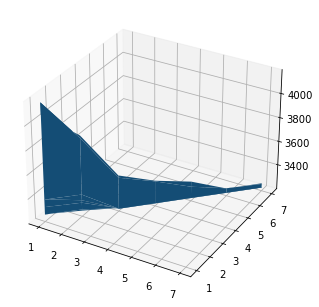

In [10]:
fig = plt.figure()
ax = Axes3D(fig)
x = range(1,8)
surf = ax.plot_surface(x, x, AIC_df_wide)

In [11]:
AIC_df[['aic']].idxmin()

aic    16
dtype: int64

In [12]:
AIC_df.iloc[16]

ar        3.000000
ma        3.000000
aic    3212.655063
Name: 16, dtype: float64

<AxesSubplot:xlabel='ar', ylabel='aic'>

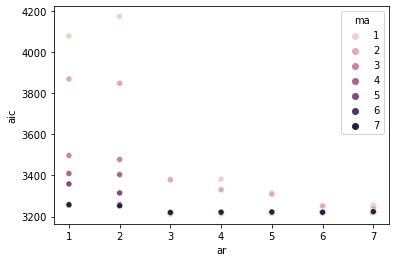

In [13]:
sns.scatterplot(data = AIC_df, x = 'ar', y = 'aic', hue = 'ma')

<AxesSubplot:xlabel='ar', ylabel='aic'>

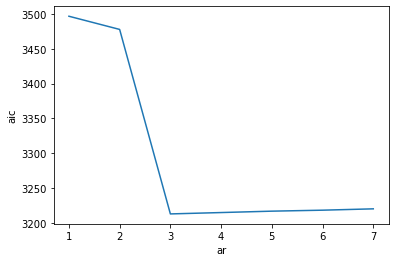

In [17]:
sns.lineplot(data = AIC_df[AIC_df['ma'] == 3], x = 'ar', y = 'aic')